In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Paso 1. Descargar los datos

In [14]:
data = pd.read_csv("/datasets/gym_churn_us.csv")

### Llevar a cabo el análisis exploratorio de datos (EDA)

In [15]:
print(data.info())
print(data.describe())

data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [16]:
data.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


### Análisis de los valores promedio y desviación estándar:

- Edad (Age): Promedio de 29 años, con una desviación estándar de 3.26. La mayoría de los clientes tienen entre 27 y 31 años.
- Tiempo desde la primera visita (Lifetime): Promedio de 3.7 meses, con una desviación de 3.7. Algunos clientes han estado hasta 31 meses.
- Período de contrato (Contract_period): Promedio de 4.68 meses, con una alta desviación de 4.54. Indica que hay clientes con contratos de distintos períodos.
- Frecuencia de asistencia:
    - Avg_class_frequency_total: Promedio de 1.87 visitas por semana.
    - Avg_class_frequency_current_month: Promedio de 1.76, lo que indica que en el último mes algunos clientes han reducido su asistencia.
- Gastos adicionales (Avg_additional_charges_total): Promedio de $146.94, con una desviación alta ($96.35), lo que sugiere grandes diferencias en el gasto entre clientes.
- Cancelación (Churn): 26.5% de los clientes cancelaron el mes siguiente.

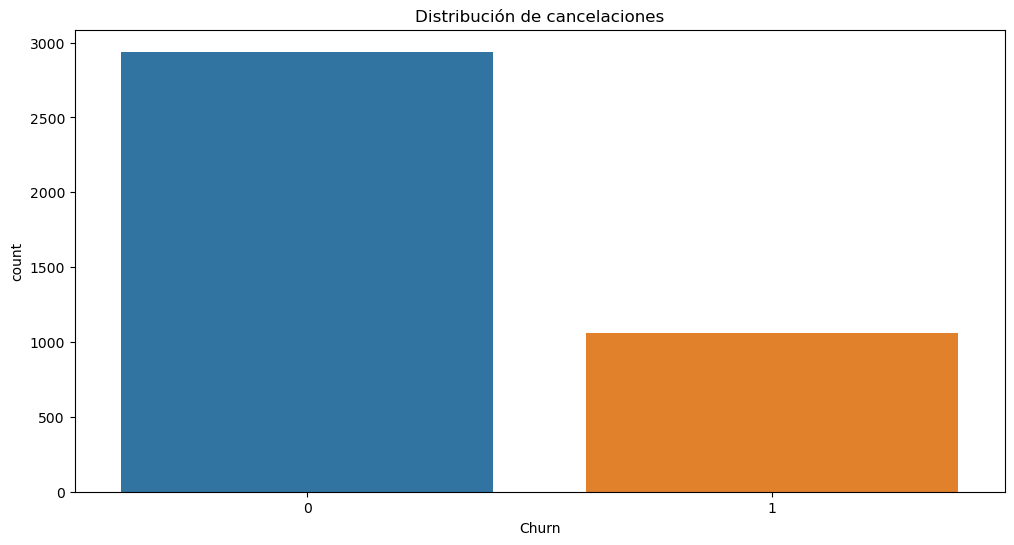

In [17]:
# Visualización de distribuciones
plt.figure(figsize=(12,6))
sns.countplot(x='Churn', data=data)
plt.title("Distribución de cancelaciones")
plt.show()

c:\Users\jafet\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jafet\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jafet\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jafet\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

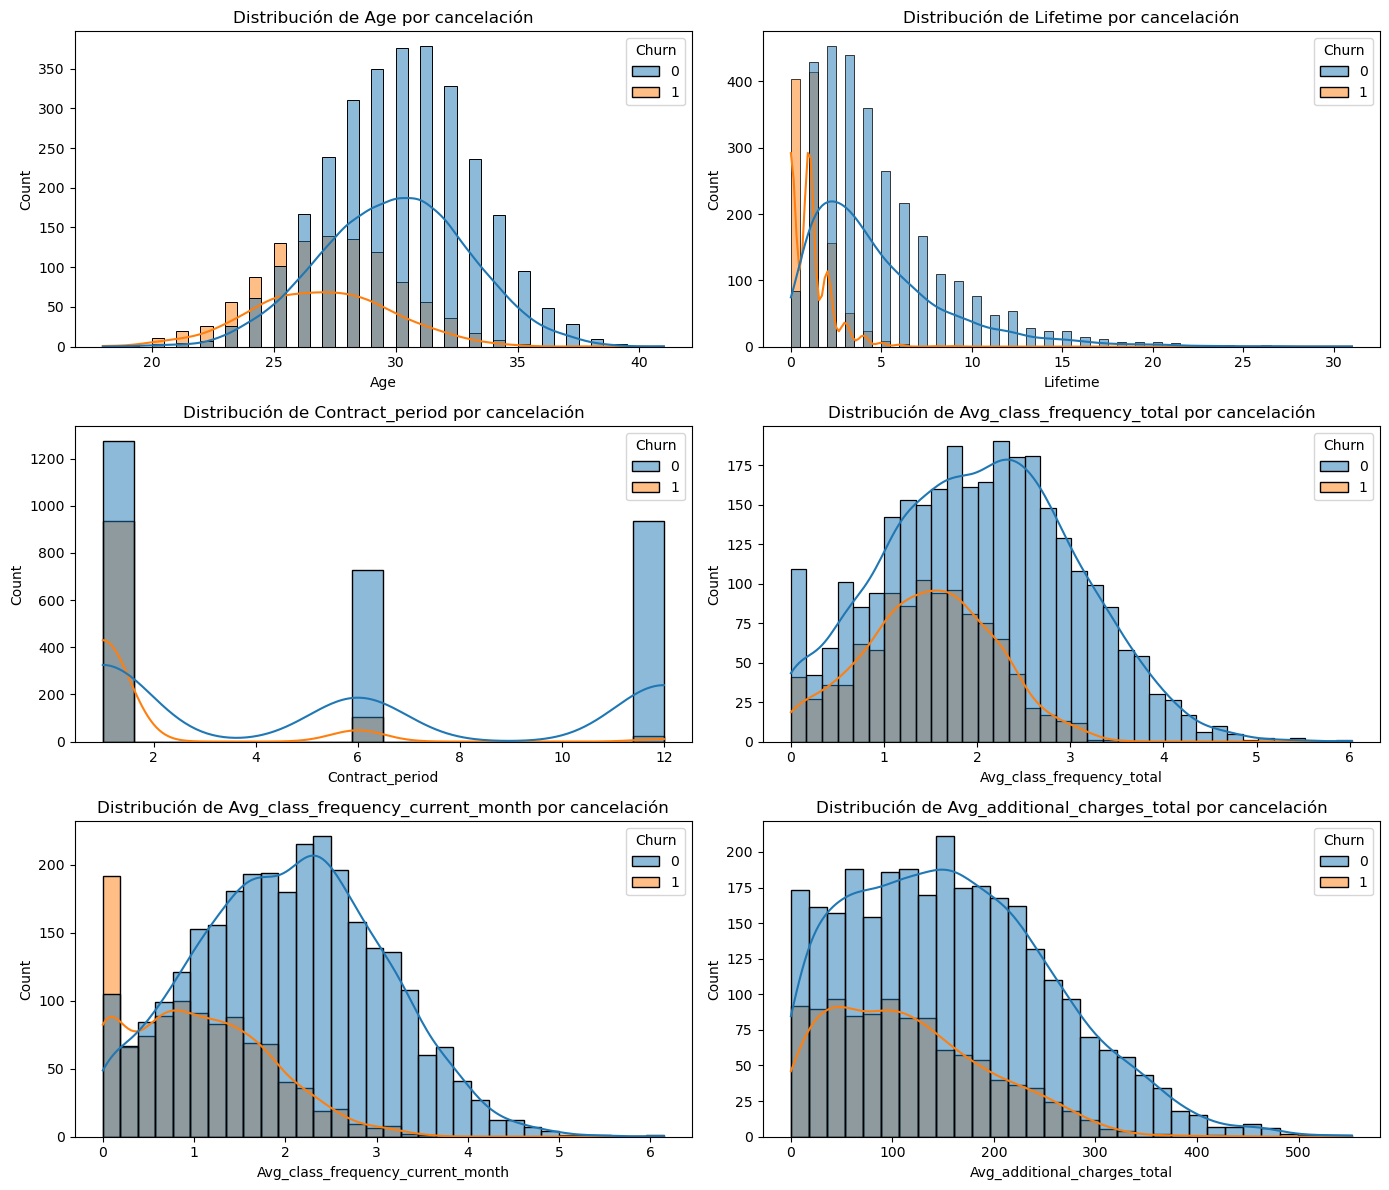

In [18]:
# Comparación de características clave
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
columns_to_compare = ['Age', 'Lifetime', 'Contract_period', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']
for col, ax in zip(columns_to_compare, axes.flatten()):
    sns.histplot(data=data, x=col, hue='Churn', kde=True, ax=ax)
    ax.set_title(f"Distribución de {col} por cancelación")
plt.tight_layout()
plt.show()

Los clientes más propensos a cancelar tienen estas características:
- Viven más lejos
- No tienen pareja
- No aprovechan promociones de amigos
- Tienen contratos cortos
- No hacen visitas en grupo
- Son más jóvenes
- Gastan menos en servicios adicionales
- Tienen menos meses restantes en su contrato
- Llevan poco tiempo como clientes
- Asisten menos al gimnasio

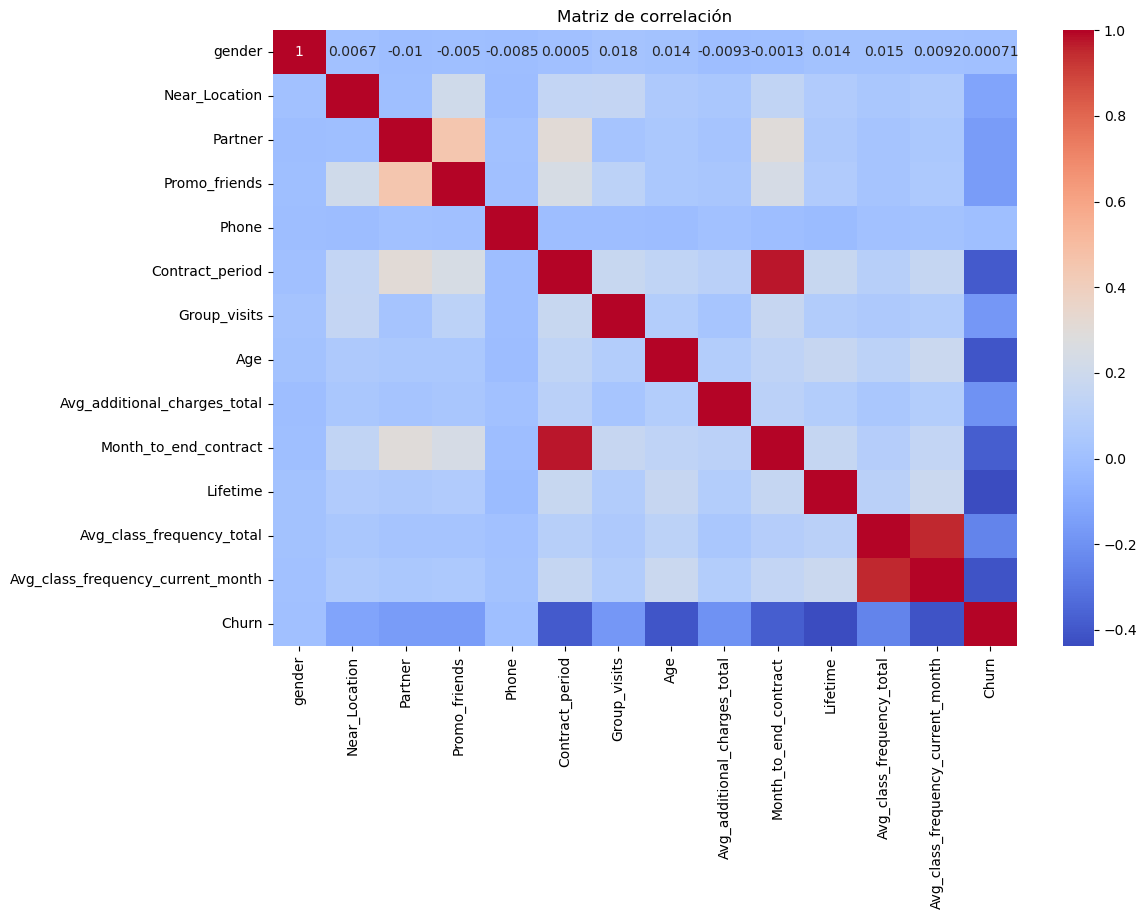

In [19]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

## Paso 3. Construir un modelo para predecir la cancelación de usuarios

In [26]:
X = data.drop(columns=['Churn'])
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")


Logistic Regression:
Accuracy: 0.92
Precision: 0.88
Recall: 0.78
F1-score: 0.83

Random Forest:
Accuracy: 0.91
Precision: 0.85
Recall: 0.77
F1-score: 0.81


Logistic Regression tiene mejor precisión y recall

- Mejor accuracy y F1-score.
- Su recall es un poco mejor que el de Random Forest, lo que significa que detecta mejor a los clientes que realmente cancelan.

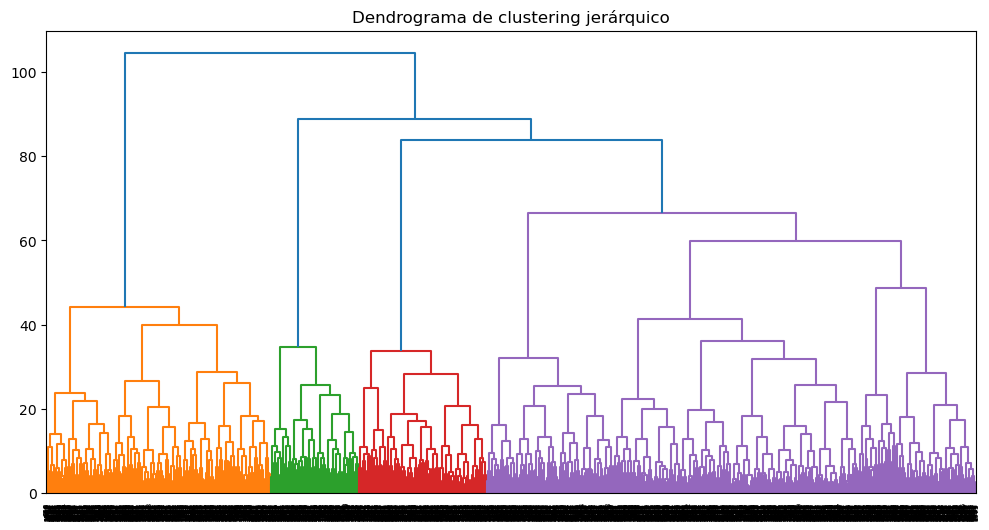

In [22]:
# Clustering
X_scaled = scaler.fit_transform(X)
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title("Dendrograma de clustering jerárquico")
plt.show()

Se pueden distinguir aproximadamente 5 grupos grandes.

In [23]:
# Aplicar K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Análisis de los clústeres
display(data.groupby('Cluster').mean())

c:\Users\jafet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774331,2.887836,3.772512,1.770536,1.669581,0.246445
1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774265,2.419573,4.780652,2.745505,2.733173,0.089989
2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509804,10.812717,4.677457,2.006405,1.998179,0.021965
3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967967,0.572942
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


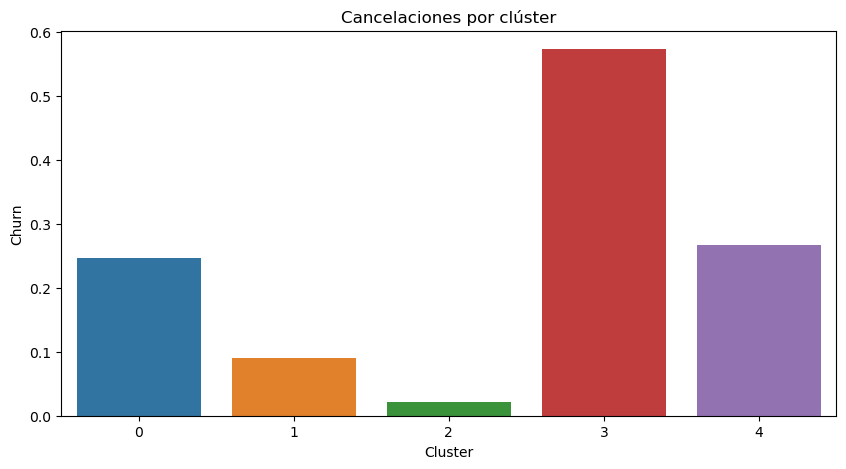

In [32]:
plt.figure(figsize=(10, 5))
sns.barplot(x=data['Cluster'], y=data['Churn'].astype(int), errorbar=None)
plt.title("Cancelaciones por clúster")
plt.show()

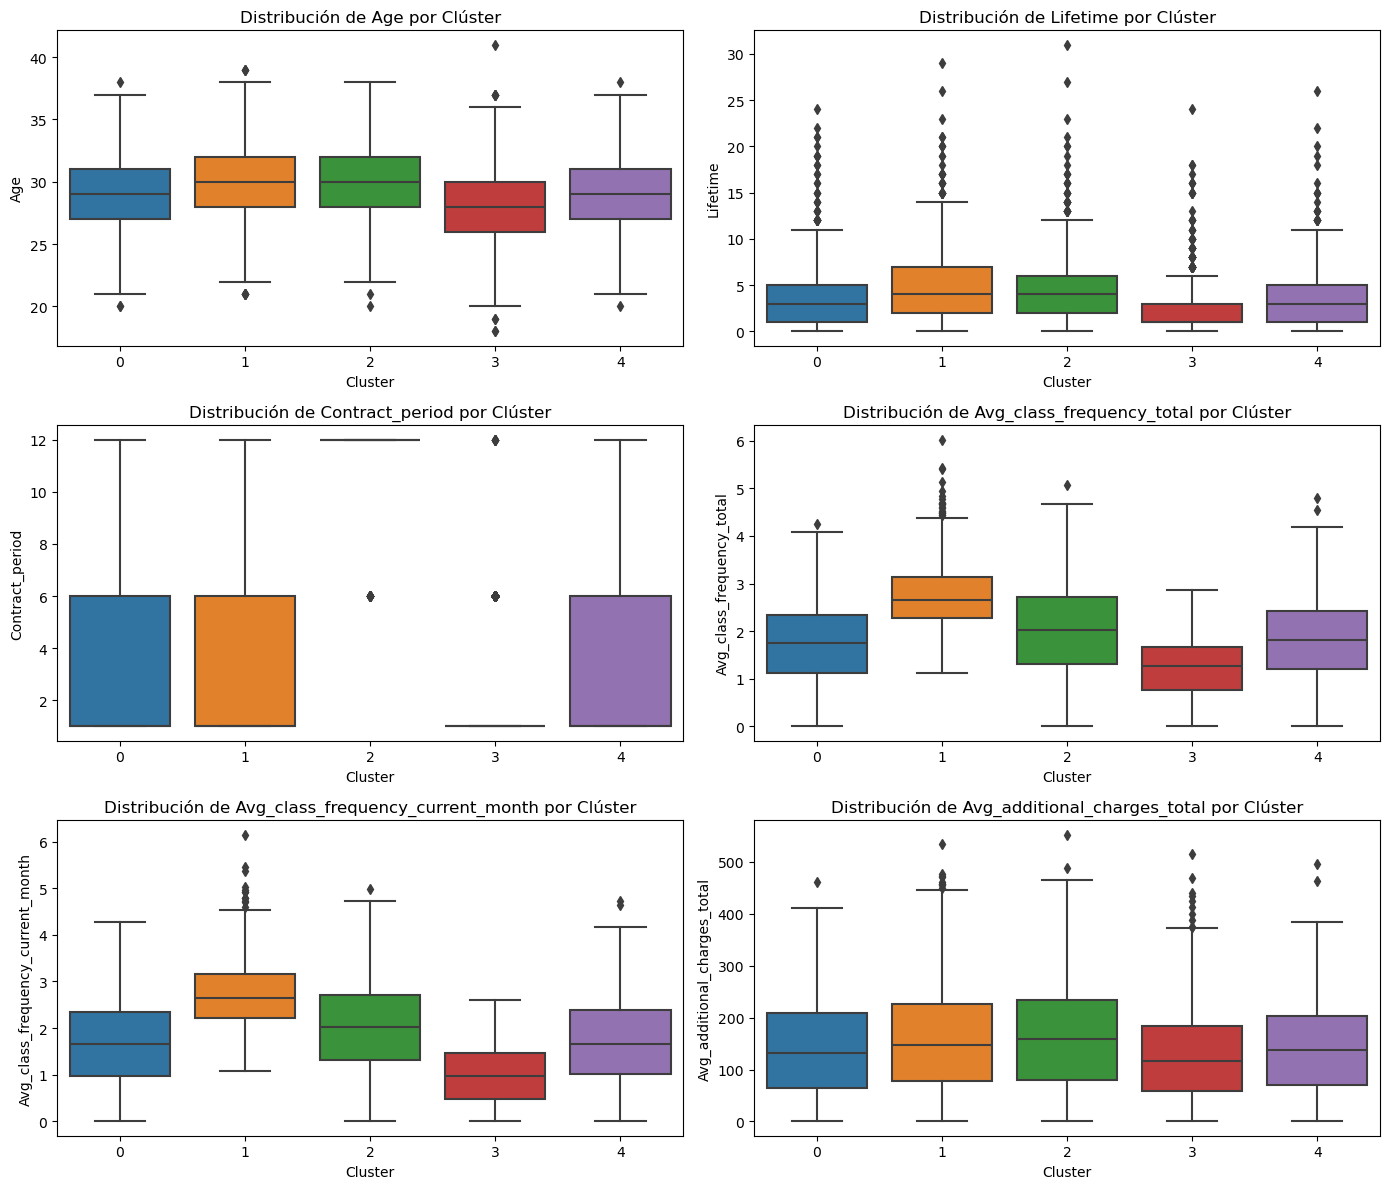

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
columns_to_compare = ['Age', 'Lifetime', 'Contract_period', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']

for col, ax in zip(columns_to_compare, axes.flatten()):
    sns.boxplot(x='Cluster', y=col, data=data, ax=ax)
    ax.set_title(f"Distribución de {col} por Clúster")
plt.tight_layout()
plt.show()

In [35]:
churn_rate_by_cluster = data.groupby('Cluster')['Churn'].mean() * 100

# Mostrar los resultados
churn_rate_by_cluster

Cluster
0    24.644550
1     8.998875
2     2.196532
3    57.294214
4    26.683938
Name: Churn, dtype: float64

## Conclusiones y Recomendaciones para la Retención de Clientes
### Conclusiones:
- Existen diferencias claras entre los clústeres en términos de retención y cancelación.

- Algunos grupos son más propensos a irse (Clúster 3 con 57.29% de cancelación), mientras que otros son leales (Clúster 2 con solo 2.19%).
Factores como la duración del contrato, la frecuencia de asistencia y el gasto adicional influyen en la retención.

- Los clientes con contratos cortos y baja frecuencia de asistencia tienen mayor probabilidad de cancelar.
Las promociones y los incentivos pueden ayudar a retener a clientes en riesgo.

- Clientes con poca interacción pueden beneficiarse de descuentos, clases gratuitas o recordatorios personalizados.

### Recomendaciones:
1. Segmentación y Personalización:
- Ofrecer incentivos a clientes en riesgo con promociones específicas.
- Recompensar la lealtad de clientes con baja cancelación con descuentos exclusivos o mejoras en la membresía.

2. Aumento de la Frecuencia de Uso
- Enviar recordatorios personalizados o planes de entrenamiento para clientes con baja asistencia.
- Crear desafíos o programas de fidelización basados en asistencia regular.

3. Extensión de Contratos y Retención Proactiva
- Ofrecer descuentos por renovación anticipada a clientes con contratos cortos.
- Proporcionar beneficios adicionales a quienes amplíen su membresía a largo plazo.

4. Optimización del Soporte al Cliente
- Realizar encuestas a clientes en riesgo para entender sus necesidades.
- Implementar un sistema de alertas tempranas para contactar a usuarios con baja actividad.